In [61]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, RFE
import warnings
warnings.filterwarnings('ignore')

Data source:
https://data.montgomerycountymd.gov/Public-Safety/Traffic-Violations/4mse-ku6q
* cut off data: 2022-08-15

In [26]:
df = pd.read_csv('Traffic_Violations_montgomery_county.csv')

In [3]:
df.head()

,SeqID,Date Of Stop,Time Of Stop,Agency,SubAgency,Description,Location,Latitude,Longitude,Accident,...,Charge,Article,Contributed To Accident,Race,Gender,Driver City,Driver State,DL State,Arrest Type,Geolocation
0,fbc324ab-bc8d-4743-ba23-7f9f370005e1,08/11/2019,20:02:00,MCP,"2nd District, Bethesda","LEAVING UNATTENDED VEH. W/O STOPPING ENGINE, L...",CORDELL ST @ NORFOLK AVE.,38.989743,-77.097770,No,...,21-1101(a),Transportation Article,False,BLACK,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(38.9897433333333, -77.09777)"
1,a6d904ec-d666-4bc3-8984-f37a4b31854d,08/12/2019,13:41:00,MCP,"2nd District, Bethesda",EXCEEDING POSTED MAXIMUM SPEED LIMIT: 85 MPH I...,NBI270 AT MIDDLEBROOK RD,39.174110,-77.246170,No,...,21-801.1,Transportation Article,False,WHITE,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(39.17411, -77.24617)"
2,54a64f6a-df28-4b65-a335-08883866aa46,08/12/2019,21:00:00,MCP,"5th District, Germantown",DRIVING VEH W/ TV-TYPE RECEIVING VIDEO EQUIP T...,MIDDLEBROOK AN 355,39.182015,-77.238221,No,...,21-1129,Transportation Article,False,BLACK,M,GAITHERSBURG,MD,MD,A - Marked Patrol,"(39.1820155, -77.2382213333333)"
3,cf5479b6-9bc7-4216-a7b2-99e57ae932af,08/12/2019,21:43:00,MCP,"5th District, Germantown",DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGI...,GERMANTOWN RD AND ALE HOUSE,39.160508,-77.284023,No,...,13-401(h),Transportation Article,False,BLACK,M,GERMANTOWN,MD,MD,A - Marked Patrol,"(39.1605076666667, -77.284023)"
4,5601ca35-8ee7-4f8e-9208-d89cde96d469,08/12/2019,21:30:00,MCP,"2nd District, Bethesda",FAILURE OF LICENSEE TO NOTIFY ADMINISTRATION O...,EASTWEST/ 355,38.984247,-77.090548,No,...,16-116(a),Transportation Article,False,BLACK,M,SILVER SPRING,MD,MD,A - Marked Patrol,"(38.9842466666667, -77.0905483333333)"


In [27]:
# drop columns
drop_col = ['SeqID', 'Agency', 'SubAgency', 'Accident', 'Fatal', 'Commercial License','HAZMAT', 'Commercial Vehicle', 
           'Work Zone', 'State', 'VehicleType', 'Year', 'Make', 'Model', 'Color', 'Charge', 'Article', 'Driver State', 'DL State', 'Search Reason For Stop', 'Search Arrest Reason', 'Location',
           'Search Conducted', 'Search Disposition', 'Search Outcome', 'Search Reason', 'Search Type','Geolocation',
           'Latitude', 'Longitude','Description', 'Driver City', 'Arrest Type']
df = df.drop(columns = drop_col)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803695 entries, 0 to 1803694
Data columns (total 10 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   Date Of Stop             object
 1   Time Of Stop             object
 2   Belts                    object
 3   Personal Injury          object
 4   Property Damage          object
 5   Alcohol                  object
 6   Violation Type           object
 7   Contributed To Accident  bool  
 8   Race                     object
 9   Gender                   object
dtypes: bool(1), object(9)
memory usage: 125.6+ MB


In [5]:
# check null value
df.isnull().sum()

Date Of Stop               0
Time Of Stop               0
Belts                      0
Personal Injury            0
Property Damage            0
Alcohol                    0
Violation Type             0
Contributed To Accident    0
Race                       0
Gender                     0
dtype: int64

In [28]:
# convert time format
df['date_time'] = df['Date Of Stop'] + ' ' + df['Time Of Stop']
col = ['Date Of Stop', 'Time Of Stop']
df = df.drop(columns = col)
df['date_time'] = pd.to_datetime(df['date_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803695 entries, 0 to 1803694
Data columns (total 9 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Belts                    object        
 1   Personal Injury          object        
 2   Property Damage          object        
 3   Alcohol                  object        
 4   Violation Type           object        
 5   Contributed To Accident  bool          
 6   Race                     object        
 7   Gender                   object        
 8   date_time                datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(7)
memory usage: 111.8+ MB


In [29]:
# set the time to index and create new columns for year, month, day of the week and hour
df.set_index('date_time', inplace=True)
df.sort_index(inplace=True)
df['month'] = df.index.strftime('%m-%b')
df['day_of_week'] = df.index.strftime('%A')
df['year'] = df.index.strftime('%Y')
df['hour'] = df.index.strftime('%H')
df.head()

,Belts,Personal Injury,Property Damage,Alcohol,Violation Type,Contributed To Accident,Race,Gender,month,day_of_week,year,hour
date_time,,,,,,,,,,,,
2012-01-01 00:43:00,No,No,No,No,Warning,False,WHITE,M,01-Jan,Sunday,2012,00
2012-01-01 00:52:00,No,No,No,No,Citation,False,HISPANIC,F,01-Jan,Sunday,2012,00
2012-01-01 00:52:00,No,No,No,No,Citation,False,HISPANIC,F,01-Jan,Sunday,2012,00
2012-01-01 00:52:00,No,No,No,No,Citation,False,HISPANIC,F,01-Jan,Sunday,2012,00
2012-01-01 00:52:00,No,No,No,No,Citation,False,HISPANIC,F,01-Jan,Sunday,2012,00


In [169]:
# df['Contributed To Accident'] = np.where(df['Contributed To Accident'] == True, 1, df['Contributed To Accident'])
# df['Contributed To Accident'] = np.where(df['Contributed To Accident'] == False, 0, df['Contributed To Accident'])

In [170]:
# split data
from sklearn.model_selection import train_test_split
import math
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df['Property Damage'])

train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate['Property Damage'])

## Data Explore

### 1. Does property damage happened related to the hour? day of week? month? year?

In [34]:
hour = pd.crosstab(train.hour, train['Property Damage'], normalize = 'index').sort_index(ascending=False)
day_of_week = pd.crosstab(train.day_of_week, train['Property Damage'], normalize = 'index').sort_index(ascending=False)
month = pd.crosstab(train.month, train['Property Damage'], normalize = 'index').sort_index(ascending=False)
year = pd.crosstab(train.year, train['Property Damage'], normalize = 'index').sort_index(ascending=False)

<AxesSubplot:ylabel='year'>

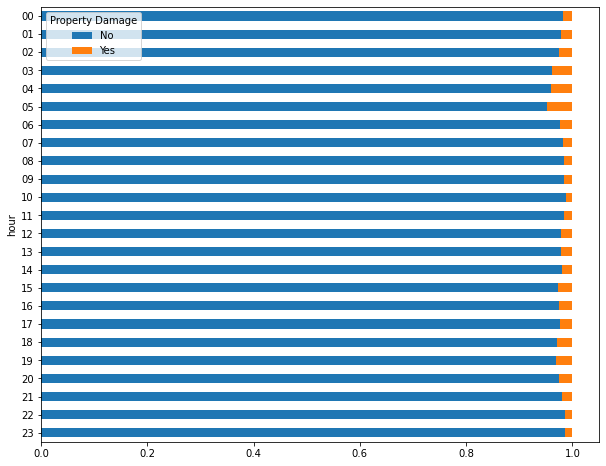

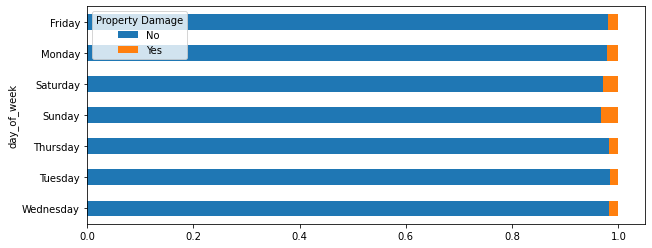

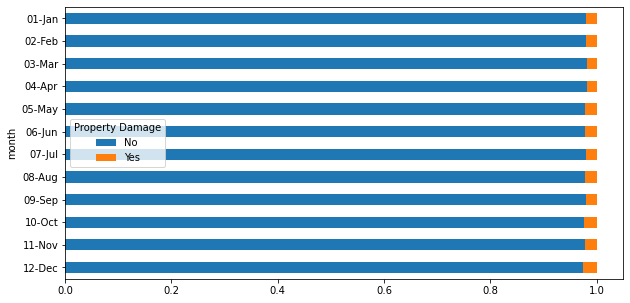

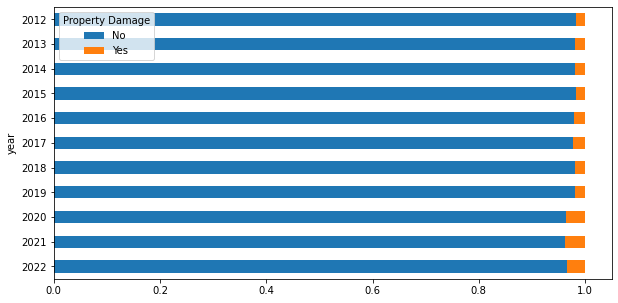

In [42]:
hour.plot.barh(stacked = True, figsize = (10, 8), fontsize = 10)
day_of_week.plot.barh(stacked = True, figsize = (10, 4), fontsize = 10)
month.plot.barh(stacked = True, figsize = (10, 5), fontsize = 10)
year.plot.barh(stacked = True, figsize = (10, 5), fontsize = 10)

In [37]:
pd.crosstab(train.year, train['Property Damage'], margins=True)

Property Damage,No,Yes,All
year,,,
2012,82946,1481,84427
2013,104476,2123,106599
2014,123739,2304,126043
2015,129323,2181,131504
2016,120100,2602,122702
2017,109255,2596,111851
2018,119679,2235,121914
2019,103604,2034,105638
2020,39024,1467,40491


In [38]:
pd.crosstab(train.hour, train['Property Damage'], margins=True)

Property Damage,No,Yes,All
hour,,,
00,55074,1001,56075
01,45009,1008,46017
02,34108,881,34989
03,21893,877,22770
04,13378,554,13932
05,9422,465,9887
06,16133,398,16531
07,37302,677,37979
08,52539,889,53428


In [41]:
year

Property Damage,No,Yes
year,,
2022,0.965708,0.034292
2021,0.962638,0.037362
2020,0.963770,0.036230
2019,0.980746,0.019254
2018,0.981667,0.018333
2017,0.976791,0.023209
2016,0.978794,0.021206
2015,0.983415,0.016585
2014,0.981721,0.018279


* Answer:
    1. hour: 03,04,05 and 18,19 have the highest damage rate.
    2. day of week: Saturday and Sunday.
    3. month: May to August = summer break; October to January = holiday seasom.
    4. year: 2020,2021,2022 are the highest, due to the pandemic, traffic violation numbers are less than before but the damage rate is higher than before.

### 2. Does property damage relate to race and gender?

<AxesSubplot:ylabel='Race'>

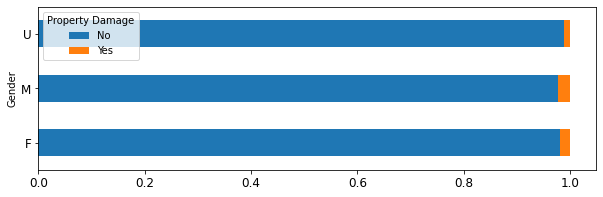

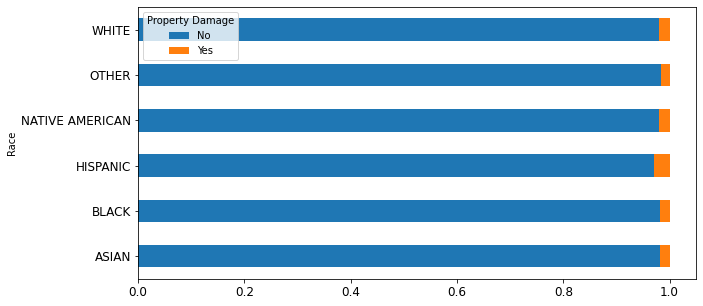

In [45]:
race = pd.crosstab(train.Race, train['Property Damage'], normalize = 'index')
gender = pd.crosstab(train.Gender, train['Property Damage'], normalize = 'index')

gender.plot.barh(stacked = True, figsize = (10, 3), fontsize = 12)
race.plot.barh(stacked = True, figsize = (10, 5), fontsize = 12)

* gender: Male has higher rate than female.
* race: hispanic has the highest rate.

### 3. What about the relationship between property damage and Violation Type? achohol? belts?

<AxesSubplot:ylabel='Belts'>

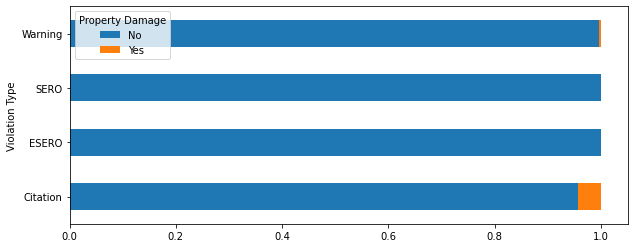

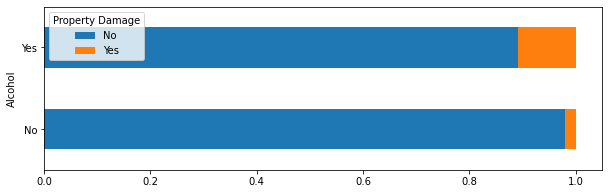

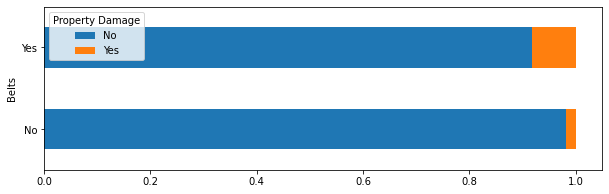

In [48]:
violation = pd.crosstab(train['Violation Type'], train['Property Damage'], normalize = 'index')
alcohol = pd.crosstab(train.Alcohol, train['Property Damage'], normalize = 'index')
belts = pd.crosstab(train.Belts, train['Property Damage'], normalize = 'index')

violation.plot.barh(stacked = True, figsize = (10, 4), fontsize = 10)
alcohol.plot.barh(stacked = True, figsize = (10, 3), fontsize = 10)
belts.plot.barh(stacked = True, figsize = (10, 3), fontsize = 10)

* violation type: citation has the highest.
* alcohol: alcohol related violation is more likely cause property damage.
* belts: the people with belts on is more likely cause property damage doesn't make sense. It might because some of the violation type doesn't related to belts, also depends on when the police officer conduct the belts check.

### 4. Is personal injury has relationship with property damage?

<AxesSubplot:ylabel='Personal Injury'>

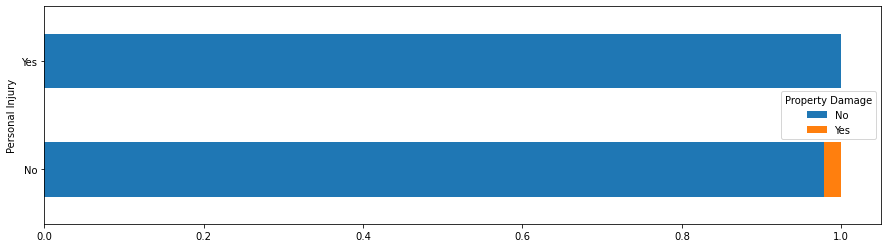

In [51]:
injury = pd.crosstab(train['Personal Injury'], train['Property Damage'], normalize = 'index')
injury.plot.barh(stacked = True, figsize = (15, 4), fontsize = 10)

* It seems normally property damage doesn't involve personal injury.

### 5. Is contributed to accident has relationship with property damage?

<AxesSubplot:ylabel='Contributed To Accident'>

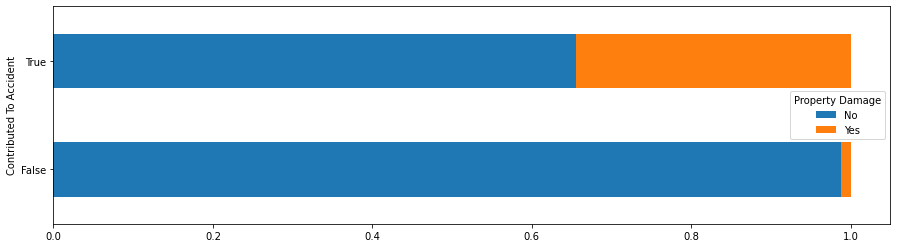

In [52]:
accident = pd.crosstab(train['Contributed To Accident'], train['Property Damage'], normalize = 'index')
accident.plot.barh(stacked = True, figsize = (15, 4), fontsize = 10)

* The violations contributed to accident has higher chance to cause property damage.

## Summary

Alcohol, Contributed To Accident, year, hour, month, day_of_week

## Clustering
since hour, day of week, month, year all represent time. I will create a time cluster to minimize the feature columns.

In [122]:
# split the data
x_train = train[['hour','month','day_of_week','year']]

In [123]:
x_train.head()

,hour,month,day_of_week,year
date_time,,,,
2013-01-06 22:58:00,22,01-Jan,Sunday,2013
2018-04-22 05:30:00,05,04-Apr,Sunday,2018
2014-09-12 10:55:00,10,09-Sep,Friday,2014
2015-10-19 11:53:00,11,10-Oct,Monday,2015
2013-10-05 01:38:00,01,10-Oct,Saturday,2013


In [124]:
x_train_dummy = pd.get_dummies(x_train, columns=['hour','month','day_of_week','year'])

In [125]:
x_train_dummy.head()

,hour_00,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,...,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-06 22:58:00,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2018-04-22 05:30:00,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2014-09-12 10:55:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2015-10-19 11:53:00,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2013-10-05 01:38:00,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


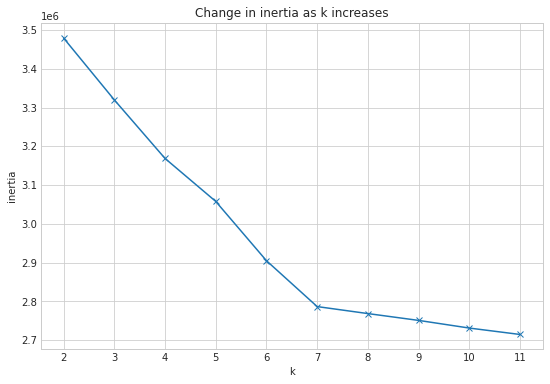

In [126]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(x_train_dummy).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* K = 7

In [127]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(x_train_dummy)

cluster_time = kmeans.predict(x_train_dummy)
x_train_dummy['claster_time'] = cluster_time

## Feature selection

In [128]:
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

In [140]:
train['claster_time'] = cluster_time
train.columns

Index(['Belts', 'Personal Injury', 'Property Damage', 'Alcohol',
       'Violation Type', 'Contributed To Accident', 'Race', 'Gender', 'month',
       'day_of_week', 'year', 'hour', 'claster_time'],
      dtype='object')

In [142]:
x_train = train[['Alcohol','Violation Type', 'Contributed To Accident','Race', 'Gender','month',
                 'day_of_week', 'year', 'hour', 'claster_time']]
y_train = train[['Property Damage']]

In [143]:
x_train_dummy_feature = pd.get_dummies(x_train)
y_train_dummy_feature = pd.get_dummies(y_train, drop_first=True)

In [144]:
x_train_dummy_feature.head()

,Contributed To Accident,claster_time,Alcohol_No,Alcohol_Yes,Violation Type_Citation,Violation Type_ESERO,Violation Type_SERO,Violation Type_Warning,Race_ASIAN,Race_BLACK,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-06 22:58:00,False,6,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2018-04-22 05:30:00,False,6,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-09-12 10:55:00,False,3,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-10-19 11:53:00,False,5,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-10-05 01:38:00,False,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [145]:
x_train_dummy_feature = pd.get_dummies(x_train_dummy_feature, columns=['claster_time'])

In [146]:
x_train_dummy_feature['Contributed To Accident'] = np.where(x_train_dummy_feature['Contributed To Accident'] == True, 
                                                            1, x_train_dummy_feature['Contributed To Accident'])
x_train_dummy_feature['Contributed To Accident'] = np.where(x_train_dummy_feature['Contributed To Accident'] == False, 
                                                            0, x_train_dummy_feature['Contributed To Accident'])

In [147]:
x_train_dummy_feature.head()

,Contributed To Accident,Alcohol_No,Alcohol_Yes,Violation Type_Citation,Violation Type_ESERO,Violation Type_SERO,Violation Type_Warning,Race_ASIAN,Race_BLACK,Race_HISPANIC,...,hour_21,hour_22,hour_23,claster_time_0,claster_time_1,claster_time_2,claster_time_3,claster_time_4,claster_time_5,claster_time_6
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-06 22:58:00,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2018-04-22 05:30:00,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2014-09-12 10:55:00,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-10-19 11:53:00,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2013-10-05 01:38:00,0,1,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [110]:
# y_train_dummy_feature['Property Damage_Yes'] = y_train_dummy_feature['Property Damage_Yes'].astype('int')

In [149]:
kbest = SelectKBest(f_regression, k=5)
kbest.fit(x_train_dummy_feature, y_train_dummy_feature)
x_train_dummy_feature.columns[kbest.get_support()]

Index(['Contributed To Accident', 'Violation Type_Citation',
       'Violation Type_ESERO', 'Violation Type_Warning', 'Race_HISPANIC'],
      dtype='object')

In [154]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
rfe.fit(x_train_dummy_feature, y_train_dummy_feature)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [168]:
a = pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=x_train_dummy_feature.columns)
a.sort_values(by = 'rfe_ranking').head(30)

,rfe_ranking
hour_08,1
hour_07,1
hour_09,1
hour_10,1
hour_11,1
hour_14,1
hour_00,1
hour_23,1
hour_21,1
hour_22,1


In [160]:
x_train_dummy_feature.columns[rfe.get_support()]

Index(['hour_00', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11',
       'hour_14', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

* cluster has no use for this project

* features will use for modeling:
    1. Contributed To Accident
    2. Alcohol
    3. Violation Type_Warning
    4. hour

In [186]:
train.head()

,Belts,Personal Injury,Property Damage,Alcohol,Violation Type,Contributed To Accident,Race,Gender,month,day_of_week,year,hour
date_time,,,,,,,,,,,,
2013-01-06 22:58:00,No,No,No,No,Citation,0,BLACK,M,01-Jan,Sunday,2013,22
2018-04-22 05:30:00,No,No,No,No,Warning,0,WHITE,M,04-Apr,Sunday,2018,05
2014-09-12 10:55:00,No,No,No,No,Citation,0,WHITE,M,09-Sep,Friday,2014,10
2015-10-19 11:53:00,No,No,No,No,Warning,0,WHITE,F,10-Oct,Monday,2015,11
2013-10-05 01:38:00,No,No,No,No,Citation,0,BLACK,F,10-Oct,Saturday,2013,01


# Modeling

In [183]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [193]:
train['baseline'] = 'No'

baseline_accuracy = (train['Property Damage'] == train.baseline).mean()

print(f'baseline accuracy on train set: {baseline_accuracy:.2%}')

baseline accuracy on train set: 97.91%


In [179]:
# split the data and get dummy variables for modeling part

x_train = train[['Alcohol','Violation Type','Contributed To Accident','hour']]
y_train = train[['Property Damage']]

x_validate = validate[['Alcohol','Violation Type','Contributed To Accident','hour']]
y_validate = validate[['Property Damage']]

x_test = test[['Alcohol','Violation Type','Contributed To Accident','hour']]
y_test = test[['Property Damage']]

x_train_dummy = pd.get_dummies(x_train, drop_first=True)
x_validate_dummy = pd.get_dummies(x_validate, drop_first=True)
x_test_dummy = pd.get_dummies(x_test, drop_first=True)

y_train_dummy = pd.get_dummies(y_train, drop_first=True)
y_validate_dummy = pd.get_dummies(y_validate, drop_first=True)
y_test_dummy = pd.get_dummies(y_test, drop_first=True)

### Baseline

## 1. Desicion Tree

In [200]:
# step 1: Creat your recipe
tree = DecisionTreeClassifier(max_depth = 2)

# Step 2: Fit your model to your in-sample data (train)
tree.fit(x_train_dummy, y_train_dummy)

# Rudimentary visualization of model structure
print(export_text(tree, feature_names=x_train_dummy.columns.tolist()))

|--- Contributed To Accident <= 0.50
|   |--- Violation Type_Warning <= 0.50
|   |   |--- class: 0
|   |--- Violation Type_Warning >  0.50
|   |   |--- class: 0
|--- Contributed To Accident >  0.50
|   |--- Alcohol_Yes <= 0.50
|   |   |--- class: 0
|   |--- Alcohol_Yes >  0.50
|   |   |--- class: 1



In [201]:
predictions = tree.predict(x_train_dummy)
actual = y_train_dummy

print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    988916
           1       0.67      0.00      0.01     21153

    accuracy                           0.98   1010069
   macro avg       0.83      0.50      0.50   1010069
weighted avg       0.97      0.98      0.97   1010069



In [197]:
for i in range(1, 10):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(x_train_dummy, y_train_dummy)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(x_train_dummy)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train_dummy, y_predictions, output_dict=True)
    print(f'Tree with max depth of {i}')
    print(pd.DataFrame(report))
    print()

Tree with max depth of 1
                       0        1  accuracy     macro avg  weighted avg
precision       0.979058      0.0  0.979058  4.895289e-01  9.585543e-01
recall          1.000000      0.0  0.979058  5.000000e-01  9.790579e-01
f1-score        0.989418      0.0  0.979058  4.947091e-01  9.686976e-01
support    988916.000000  21153.0  0.979058  1.010069e+06  1.010069e+06

Tree with max depth of 2
                       0             1  accuracy     macro avg  weighted avg
precision       0.979133      0.672414  0.979097  8.257732e-01  9.727093e-01
recall          0.999962      0.003687  0.979097  5.018245e-01  9.790975e-01
f1-score        0.989438      0.007335  0.979097  4.983861e-01  9.688702e-01
support    988916.000000  21153.000000  0.979097  1.010069e+06  1.010069e+06

Tree with max depth of 3
                       0             1  accuracy     macro avg  weighted avg
precision       0.979121      0.855263  0.979111  9.171919e-01  9.765268e-01
recall          0.999989

In [198]:
metrics = []

for i in range(1, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(x_train_dummy, y_train_dummy)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(x_train_dummy, y_train_dummy)
    
    out_of_sample_accuracy = tree.score(x_validate_dummy, y_validate_dummy)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.979058,0.979059,-0.000001
1,2,0.979097,0.979089,0.000008
2,3,0.979111,0.979085,0.000027
3,4,0.979111,0.979085,0.000027
4,5,0.979112,0.979085,0.000028
5,6,0.979113,0.979087,0.000026
6,7,0.979114,0.979082,0.000032
7,8,0.979114,0.979082,0.000032
8,9,0.979114,0.979082,0.000032
9,10,0.979114,0.979082,0.000032


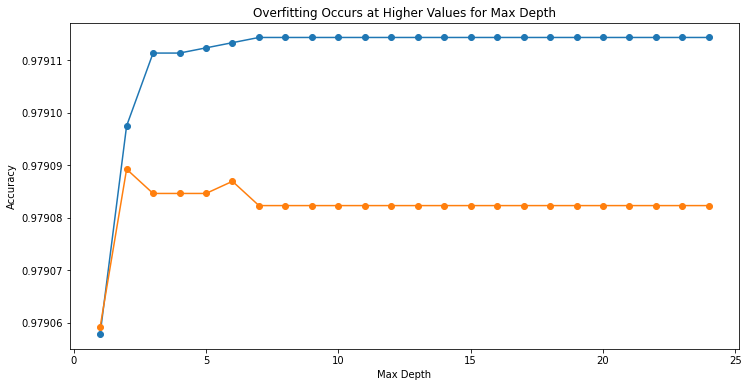

In [199]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

## 2. Random forest

In [207]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=5, 
                            min_samples_leaf=1,
                            random_state=123)
rf.fit(x_train_dummy, y_train_dummy)
y_pred = rf.predict(x_train_dummy)
y_pred_proba = rf.predict_proba(x_train_dummy)
print(classification_report(y_train_dummy, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    988916
           1       1.00      0.00      0.00     21153

    accuracy                           0.98   1010069
   macro avg       0.99      0.50      0.50   1010069
weighted avg       0.98      0.98      0.97   1010069



In [205]:
metrics = []

for i in range(1,10):
    rf = RandomForestClassifier(max_depth=(10-i), 
                            min_samples_leaf=i,
                            random_state=123)
    
    rf = rf.fit(x_train_dummy, y_train_dummy)
    
    in_sample_accuracy = rf.score(x_train_dummy, y_train_dummy)
    
    out_of_sample_accuracy = rf.score(x_validate_dummy, y_validate_dummy)
    
    output = {"max_depth": (10-i),"min_sample_lead" :i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy}
        
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,min_sample_lead,train_accuracy,validate_accuracy,difference
0,9,1,0.979113,0.979087,0.000026
1,8,2,0.979111,0.979085,0.000027
2,7,3,0.979110,0.979087,0.000023
3,6,4,0.979071,0.979073,-0.000002
4,5,5,0.979058,0.979059,-0.000001
5,4,6,0.979058,0.979059,-0.000001
6,3,7,0.979058,0.979059,-0.000001
7,2,8,0.979058,0.979059,-0.000001
8,1,9,0.979058,0.979059,-0.000001


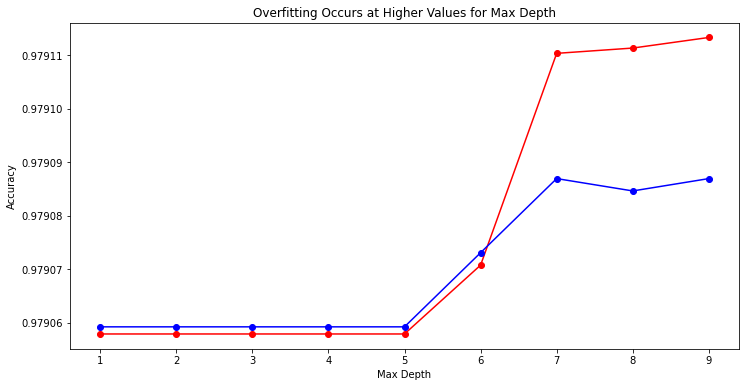

In [206]:
plt.figure(figsize=(12, 6))
plt.plot(df.max_depth, df.train_accuracy, color = 'r', marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, color = 'b', marker = 'o')
plt.title('Overfitting Occurs at Higher Values for Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

### 3. Logistic Regression

In [214]:
from sklearn.linear_model import LogisticRegression
# Define the logistic regression model
logit = LogisticRegression(C=1, random_state=123)

#  fit the model on train data
logit.fit(x_train_dummy, y_train_dummy)

# now use the model to make predictions
y_pred = logit.predict(x_train_dummy)

y_pred_proba = logit.predict_proba(x_train_dummy)

print(classification_report(y_train_dummy, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    988916
           1       0.67      0.00      0.01     21153

    accuracy                           0.98   1010069
   macro avg       0.83      0.50      0.50   1010069
weighted avg       0.97      0.98      0.97   1010069

